In [1]:
import sys
sys.path.append("../input/tez-lib/")
sys.path.append("../input/timmmaster/")

## Import libraries

In [2]:
import tez
import os
import albumentations
import pandas as pd
import cv2
import numpy as np
import torch
import torch.nn as nn
import math
import random
import timm
import gc

from sklearn import metrics
from tez.callbacks import EarlyStopping
from tqdm import tqdm

ONLY_ONE_FOLD=False

## import RAPDIS

In [3]:
import cuml, pickle
from cuml.svm import SVR
print('RAPIDS version', cuml.__version__,'\n')

LOAD_SVR_FROM_PATH = None

df = pd.read_csv('../input/pet-remove-dup-ver4/train_remove_dup_pseudo_10folds_ver2.csv')
print('Train shape:', df.shape )
df.head()

RAPIDS version 21.08.02 

Train shape: (24077, 3)


,Id,Pawpularity,kfold
0,0007de18844b0dbbb5e1f607da0606e0,63,1
1,0009c66b9439883ba2750fb825e1d7db,42,8
2,0013fd999caf9a3efe1352ca1b0d937e,28,2
3,0018df346ac9c1d8413cfcc888ca8246,15,6
4,001dc955e10590d3ca4673f034feeef2,72,6


## Set seed

In [4]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    #torch.cuda.manual_seed_all(seed) # if use multi-GPU

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(2021)
print("set seed")

set seed


In [5]:
class args:
    batch_size = 16
    image_size = 224
    epochs = 20
    fold = 10
    head_out = 192
    #features = 0

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

In [6]:
class PawpularDataset:
    def __init__(self, image_paths, targets, augmentations):
        self.image_paths = image_paths
        #self.dense_features = dense_features
        self.targets = targets
        self.augmentations = augmentations
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, item):
        image = cv2.imread(self.image_paths[item])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.augmentations is not None:
            augmented = self.augmentations(image=image)
            image = augmented["image"]
        
        # (720, 405, 3) -> (3, 720, 405)
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        
        #features = self.dense_features[item, :]
        targets = self.targets[item] / 100.0
        
        return {
            "image": torch.tensor(image, dtype=torch.float),
            #"features": torch.tensor(features, dtype=torch.float),
            "targets": torch.tensor(targets, dtype=torch.float),
        }

In [7]:
class PawpularModel(tez.Model):
    def __init__(self, model_name, train=True, head_out=128):
        super().__init__()
        
        self.model = timm.create_model(model_name, pretrained=train, in_chans=3)
        self.model.head = nn.Linear(self.model.head.in_features, head_out)
        self.dropout = nn.Dropout(0.2)
        self.dense1 = nn.Linear(head_out, 64)
        self.selu = nn.SELU()
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(64, head_out)
        self.dense3 = nn.Linear(head_out, 32)
        self.dense4 = nn.Linear(32, 1)
        self.dense4.bias.data = torch.nn.Parameter(
            torch.Tensor([0.0])
        )
        
    def forward(self, image, targets=None):
        
        x1 = self.model(image) 
        x = self.dense1(x1) 
        x = self.selu(x)
        x = self.dense2(x) 
        x = x*0.7 + x1*0.3
        x = self.selu(x)
        x = self.dense3(x)
        x = self.relu(x)
        x = self.dense4(x)
        x = torch.cat([x, x1], dim=1)
        
        return x, 0, {}

In [8]:
test_aug = albumentations.Compose(
    [
        albumentations.Resize(args.image_size, args.image_size, p=1),
        albumentations.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
            max_pixel_value=255.0,
            p=1.0,
        ),
    ],
    p=1.0,
)

## Infer Test and OOF

In [9]:
%%time

super_final_predictions = []
super_final_predictions2 = []
super_final_oof_predictions = []
super_final_oof_predictions2 = []
super_final_oof_true = []

for fold_ in range(args.fold):
    print('#'*25)
    print('### FOLD',fold_+1)
    print('#'*25)

    model = PawpularModel(model_name='swin_large_patch4_window7_224', train=False,
                           head_out=args.head_out)
    model.load(f"../input/paw-ver11-model/model_f{fold_}.bin", device="cuda", weights_only=True)

    df_test = pd.read_csv("../input/petfinder-pawpularity-score/test.csv")
    test_img_paths = [f"../input/petfinder-pawpularity-score/test/{x}.jpg" for x in df_test["Id"].values]
        
    df_valid = df[df.kfold == fold_].reset_index(drop=True)#.iloc[:160]
    valid_img_paths = [f"../input/my-petfinder-pawpularity-score/train/{x}.jpg" for x in df_valid["Id"].values]

    #dense_features = [
    #    'Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
    #    'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'
    #]
    
    name = f"SVR_fold_{fold_}.pkl" 
    if LOAD_SVR_FROM_PATH is None:
        ##################
        # EXTRACT TRAIN EMBEDDINGS
        
        df_train = df[df.kfold != fold_].reset_index(drop=True)#.iloc[:320]
        train_img_paths = [f"../input/my-petfinder-pawpularity-score/train/{x}.jpg" for x in df_train["Id"].values]
        
        train_dataset = PawpularDataset(
            image_paths=train_img_paths,
            #dense_features=df_train[dense_features].values,
            targets=df_train['Pawpularity'].values,
            augmentations=test_aug,
        )
        print('Extracting train embedding...')
        train_predictions = model.predict(train_dataset, batch_size=args.batch_size, n_jobs=-1)
    
        embed = np.array([]).reshape((0, args.head_out))
        for preds in train_predictions:
            # preds[:, 1:]는 마지막 cat([x, x1], dim=1)에서 최종값 x를 제외하기 위한 것이네.
            # 추출하는 건 swin model의 첫 output x1 + meta feature 
            embed = np.concatenate([embed, preds[:,1:]], axis=0)
        
        ##################
        # FIT RAPIDS SVR
        print('Fitting SVR...')
        clf = SVR(C=20.0)
        clf.fit(embed.astype('float32'), df_train.Pawpularity.values.astype('int32'))
    
        ##################
        # SAVE RAPIDS SVR 
        pickle.dump(clf, open(name, "wb"))
        
    else:
        ##################
        # LOAD RAPIDS SVR 
        print('Loading SVR...',LOAD_SVR_FROM_PATH+name)
        clf = pickle.load(open(LOAD_SVR_FROM_PATH+name, "rb"))

    ##################
    # TEST PREDICTIONS
    test_dataset = PawpularDataset(
        image_paths=test_img_paths,
        #dense_features=df_test[dense_features].values,
        targets=np.ones(len(test_img_paths)),
        augmentations=test_aug,
    )
    print('Predicting test...')
    test_predictions = model.predict(test_dataset, batch_size=args.batch_size, n_jobs=-1)

    final_test_predictions = []
    embed = np.array([]).reshape((0, args.head_out))
    for preds in test_predictions: #tqdm
        final_test_predictions.extend(preds[:,:1].ravel().tolist())
        embed = np.concatenate([embed,preds[:,1:]],axis=0)

    final_test_predictions = [sigmoid(x) * 100 for x in final_test_predictions]
    final_test_predictions2 = clf.predict(embed)
    super_final_predictions.append(final_test_predictions)
    super_final_predictions2.append(final_test_predictions2)
    ##################
    
    ##################
    # OOF PREDICTIONS
    valid_dataset = PawpularDataset(
        image_paths=valid_img_paths,
        #dense_features=df_valid[dense_features].values,
        targets=df_valid['Pawpularity'].values,
        augmentations=test_aug,
    )
    print('Predicting oof...')
    valid_predictions = model.predict(valid_dataset, batch_size=args.batch_size, n_jobs=-1)

    final_oof_predictions = []
    embed = np.array([]).reshape((0, args.head_out))
    for preds in valid_predictions:
        final_oof_predictions.extend(preds[:,:1].ravel().tolist())
        embed = np.concatenate([embed,preds[:,1:]],axis=0)

    final_oof_predictions = [sigmoid(x) * 100 for x in final_oof_predictions]
    final_oof_predictions2 = clf.predict(embed)    
    super_final_oof_predictions.append(final_oof_predictions)
    super_final_oof_predictions2.append(final_oof_predictions2)
    
    final_oof_true = df_valid['Pawpularity'].values
    super_final_oof_true.append(final_oof_true)
    ##################
    
    ##################
    # COMPUTE RSME
    rsme = np.sqrt( np.mean( (super_final_oof_true[-1] - np.array(super_final_oof_predictions[-1]))**2.0 ) )
    print('NN RSME =',rsme,'\n')
    rsme = np.sqrt( np.mean( (super_final_oof_true[-1] - np.array(super_final_oof_predictions2[-1]))**2.0 ) )
    print('SVR RSME =',rsme,'\n')
    
    w = 0.5
    oof2 = (1-w)*np.array(super_final_oof_predictions[-1]) + w*np.array(super_final_oof_predictions2[-1])
    rsme = np.sqrt( np.mean( (super_final_oof_true[-1] - oof2)**2.0 ) )
    print('Ensemble RSME =',rsme,'\n')

#########################
### FOLD 1
#########################
Extracting train embedding...


100%|██████████| 1355/1355 [06:24<00:00,  3.52it/s, stage=test]


Fitting SVR...
Predicting test...


100%|██████████| 1/1 [00:00<00:00,  2.48it/s, stage=test]


Predicting oof...


100%|██████████| 151/151 [00:42<00:00,  3.55it/s, stage=test]


NN RSME = 21.87076213426693 

SVR RSME = 18.34926285125973 

Ensemble RSME = 18.961972934072556 

#########################
### FOLD 2
#########################
Extracting train embedding...


100%|██████████| 1355/1355 [06:05<00:00,  3.71it/s, stage=test]


Fitting SVR...
Predicting test...


100%|██████████| 1/1 [00:00<00:00,  2.23it/s, stage=test]


Predicting oof...


100%|██████████| 151/151 [00:39<00:00,  3.83it/s, stage=test]


NN RSME = 22.979213212836335 

SVR RSME = 19.1417416771014 

Ensemble RSME = 19.895623069766813 

#########################
### FOLD 3
#########################
Extracting train embedding...


100%|██████████| 1355/1355 [06:06<00:00,  3.70it/s, stage=test]


Fitting SVR...
Predicting test...


100%|██████████| 1/1 [00:00<00:00,  2.77it/s, stage=test]


Predicting oof...


100%|██████████| 151/151 [00:39<00:00,  3.78it/s, stage=test]


NN RSME = 22.35022976874255 

SVR RSME = 18.368890481778823 

Ensemble RSME = 19.2228466323464 

#########################
### FOLD 4
#########################
Extracting train embedding...


100%|██████████| 1355/1355 [06:03<00:00,  3.73it/s, stage=test]


Fitting SVR...
Predicting test...


100%|██████████| 1/1 [00:00<00:00,  1.88it/s, stage=test]


Predicting oof...


100%|██████████| 151/151 [00:40<00:00,  3.69it/s, stage=test]


NN RSME = 22.72736497861887 

SVR RSME = 18.677310827432542 

Ensemble RSME = 19.517863768069475 

#########################
### FOLD 5
#########################
Extracting train embedding...


100%|██████████| 1355/1355 [06:03<00:00,  3.72it/s, stage=test]


Fitting SVR...
Predicting test...


100%|██████████| 1/1 [00:00<00:00,  2.17it/s, stage=test]


Predicting oof...


100%|██████████| 151/151 [00:42<00:00,  3.59it/s, stage=test]


NN RSME = 22.320325075291475 

SVR RSME = 18.598553253723637 

Ensemble RSME = 19.27343898049811 

#########################
### FOLD 6
#########################
Extracting train embedding...


100%|██████████| 1355/1355 [06:16<00:00,  3.60it/s, stage=test]


Fitting SVR...
Predicting test...


100%|██████████| 1/1 [00:00<00:00,  2.35it/s, stage=test]


Predicting oof...


100%|██████████| 151/151 [00:41<00:00,  3.67it/s, stage=test]


NN RSME = 22.197891000723686 

SVR RSME = 18.658645164495063 

Ensemble RSME = 19.240035012713886 

#########################
### FOLD 7
#########################
Extracting train embedding...


100%|██████████| 1355/1355 [06:20<00:00,  3.56it/s, stage=test]


Fitting SVR...
Predicting test...


100%|██████████| 1/1 [00:00<00:00,  2.91it/s, stage=test]


Predicting oof...


100%|██████████| 151/151 [00:41<00:00,  3.68it/s, stage=test]


NN RSME = 22.48911173355616 

SVR RSME = 18.708734251994432 

Ensemble RSME = 19.42046952896813 

#########################
### FOLD 8
#########################
Extracting train embedding...


100%|██████████| 1355/1355 [06:05<00:00,  3.71it/s, stage=test]


Fitting SVR...
Predicting test...


100%|██████████| 1/1 [00:00<00:00,  2.91it/s, stage=test]


Predicting oof...


100%|██████████| 151/151 [00:41<00:00,  3.68it/s, stage=test]


NN RSME = 22.898813208894545 

SVR RSME = 19.053201256036 

Ensemble RSME = 19.79411319300342 

#########################
### FOLD 9
#########################
Extracting train embedding...


100%|██████████| 1355/1355 [06:04<00:00,  3.72it/s, stage=test]


Fitting SVR...
Predicting test...


100%|██████████| 1/1 [00:00<00:00,  2.93it/s, stage=test]


Predicting oof...


100%|██████████| 151/151 [00:40<00:00,  3.70it/s, stage=test]


NN RSME = 22.166326211822444 

SVR RSME = 18.51883944262671 

Ensemble RSME = 19.185503817764523 

#########################
### FOLD 10
#########################
Extracting train embedding...


100%|██████████| 1355/1355 [06:05<00:00,  3.71it/s, stage=test]


Fitting SVR...
Predicting test...


100%|██████████| 1/1 [00:00<00:00,  2.93it/s, stage=test]


Predicting oof...


100%|██████████| 151/151 [00:41<00:00,  3.67it/s, stage=test]

NN RSME = 22.11292674475713 

SVR RSME = 18.48845910439097 

Ensemble RSME = 19.113483668885408 

CPU times: user 46min 47s, sys: 1min 22s, total: 48min 10s
Wall time: 1h 11min 3s


## Compute CV score

In [10]:
true = np.hstack(super_final_oof_true)

oof = np.hstack(super_final_oof_predictions)
rsme = np.sqrt( np.mean( (oof - true)**2.0 ))
print('Overall CV NN head RSME =',rsme)

oof2 = np.hstack(super_final_oof_predictions2)
rsme = np.sqrt( np.mean( (oof2 - true)**2.0 ))
print('Overall CV SVR head RSME =',rsme)

oof3 = (1-w)*oof + w*oof2
#oof3 = (1-best_w)*oof + best_w*oof2
rsme = np.sqrt( np.mean( (oof3 - true)**2.0 ))
print('Overall CV Ensemble heads RSME with 50% NN and 50% SVR =',rsme)

Overall CV NN head RSME = 22.413897487483283
Overall CV SVR head RSME = 18.65803137346057
Overall CV Ensemble heads RSME with 50% NN and 50% SVR = 19.36458554678469


## Find best ensemble weight

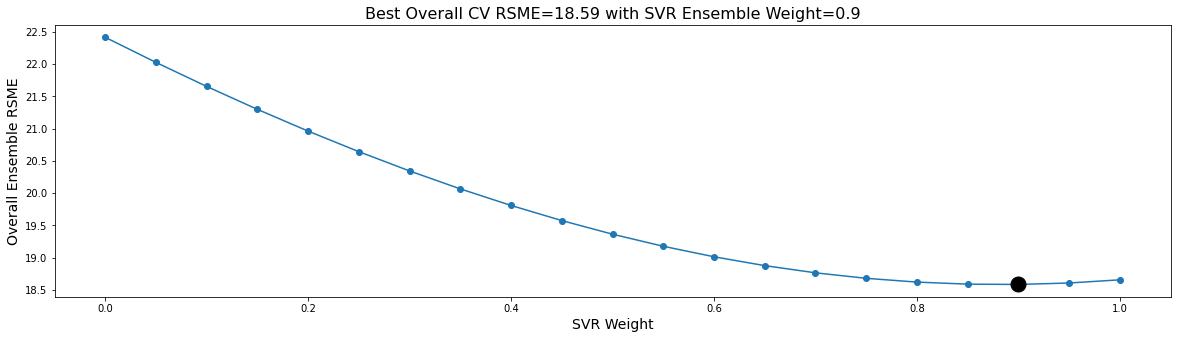

0.9


In [11]:
import matplotlib.pyplot as plt

score = []
for ww in np.arange(0,1.05,0.05):
    oof3 = (1-ww)*oof + ww*oof2
    rsme = np.sqrt( np.mean( (oof3 - true)**2.0 ))
    #print(f'{ww:0.2} CV Ensemble RSME =',rsme)
    score.append(rsme)
best_w = np.argmin(score)*0.05

plt.figure(figsize=(20,5))
plt.plot(np.arange(21)/20.0,score,'-o')
plt.plot([best_w],np.min(score),'o',color='black',markersize=15)
plt.title(f'Best Overall CV RSME={np.min(score):.4} with SVR Ensemble Weight={best_w:.2}',size=16)
plt.ylabel('Overall Ensemble RSME',size=14)
plt.xlabel('SVR Weight',size=14)
plt.show()

print(best_w)

## Make submission csv

In [12]:
super_final_predictions = np.mean(np.column_stack(super_final_predictions), axis=1)
super_final_predictions2 = np.mean(np.column_stack(super_final_predictions2), axis=1)
df_test["Pawpularity"] = (1-best_w)*super_final_predictions + best_w*super_final_predictions2
df_test = df_test[["Id", "Pawpularity"]]
df_test.to_csv("submission.csv", index=False)
df_test.head()

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,36.758657
1,43a2262d7738e3d420d453815151079e,36.614798
2,4e429cead1848a298432a0acad014c9d,36.944297
3,80bc3ccafcc51b66303c2c263aa38486,37.217009
4,8f49844c382931444e68dffbe20228f4,36.534157
